# 3) Data Modeling - US Hit Streaming Songs Project

**The following Jupyter Notebook models the data collected and analyzed in the previous sections of this project.** The modeling portion will be split in the following sections:
- Package and Data Imports
- K Means Clustering on all top 50 Songs
- Cluster Visualization and Principle Component Analysis
- Profiling the Clusters of Songs

__Overview__: Given __the goal of this project, understanding what types of song categories songs fall into__, and the fact that __the data is unlabeled__ (although genres could be added to the data, there are many songs that are genre-ambiguous), an __unsupervised clustering model is necessary__. In each cluster, songs should share similar characteristics with one another. The __K-Means Clustering algorithm is to be used for this model as it was one of the simplest ones to implement.__

I ultimately decided to isolate five variables from the dataset to cluster (acousticness, danceability, speechiness, energy, and instrumentalness). From here, I decided on the number of clusters (k) using the elbow method (graphing the sum of squared differences for each datapoint relative to each cluster centroid for a range of different k values). After this, I performed Principle Component Analysis (which scales down the dataset's dimensions to make our results graphable while retaining as much explained variation in the resulting data as possible) and graphed the results using bar graphs and radar charts. Finally, I determined that __the four main types of songs that entered the top 50 since 2017 can be categorized as the following: dancy/energetic songs with higher speechiness levels, dancy/energetic songs with lower speechiness levels, acoustic/acoustic-leaning songs, and songs with higher-than-normal instrumentalness__. At the end of this Notebook, several randomly selected songs are shown for each cluster. Once I completed the model, I played around with the results using different numbers of clusters and different combinations of variables to train the model. From this, I determined that my preferred model results came from the aforementioned variables and the number of clusters originally used in the creation of this model. The following are my finalized results:


# Imports
To start, we import necessary tools and the data collected previously. 

In [1]:
#for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to remove the limits on a dataframe's columns displayed
pd.set_option('display.max_columns', None)

#to access google sheets with python
import gspread
from google.oauth2 import service_account
from oauth2client.service_account import ServiceAccountCredentials

#for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import spreadsheet service account
sa = gspread.service_account(filename="gspread_service_account.json")

#sheet
sh = sa.open("HITS Streaming Songs")

#worksheet
wks = sh.worksheet("DF to Gspread")

#uses all values in the worksheet for the data frame
gsheets_df_updated = pd.DataFrame(wks.get_all_values())

header = gsheets_df_updated.iloc[0] #isolate first row as header
gsheets_df_updated = gsheets_df_updated[1:] #get rid of header in original df
gsheets_df_updated.columns = header

#set 'index' as index
gsheets_df_updated = gsheets_df_updated.set_index('index')

#convert index from string to int
gsheets_df_updated.index = gsheets_df_updated.index.astype(int)

#turn peak_date strings to date format
gsheets_df_updated['peak_date'] = pd.to_datetime(gsheets_df_updated['peak_date'])
gsheets_df_updated['release_date'] = pd.to_datetime(gsheets_df_updated['release_date'])

#change the following columns to int/float/boolean format
gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'] = gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'].astype(int)
gsheets_df_updated.loc[:,'length':'valence'] = gsheets_df_updated.loc[:,'length':'valence'].astype(float)
gsheets_df_updated['explicit'] = gsheets_df_updated['explicit'].apply(eval)

#drop christmas songs
gsheets_df_updated.drop(gsheets_df_updated[gsheets_df_updated['holiday_music']==1].index,inplace=True)
gsheets_df_updated.reset_index(drop=True, inplace=True)

#drop unnessesary columns
cols_to_drop = list(gsheets_df_updated.iloc[:,5:-15].columns)
cols_to_drop.extend(['popularity','key','mode','explicit'])
gsheets_df_updated.drop(cols_to_drop, axis=1, inplace=True)

gsheets_df_updated

,title,artist,album,peak_date,streams_2017_to_present,length,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence
0,Closer,The Chainsmokers,Closer,2016-09-09,10948414,244960.0,0.414,0.748,0.524,0.000000,0.1110,-5.599,0.0338,95.010,4.0,0.661
1,Fake Love,Drake,More Life,2016-11-04,40163498,210937.0,0.105,0.928,0.481,0.000000,0.1760,-9.350,0.2870,134.007,4.0,0.613
2,Starboy,The Weeknd,Starboy,2016-11-25,10554623,230453.0,0.141,0.679,0.587,0.000006,0.1370,-7.015,0.2760,186.003,4.0,0.486
3,Reminder,The Weeknd,Starboy,2016-11-25,5229932,218880.0,0.142,0.706,0.505,0.000000,0.1640,-6.923,0.1930,160.053,4.0,0.388
4,Both (feat. Drake),Gucci Mane,The Return of East Atlanta Santa,2016-12-16,23375700,190311.0,0.119,0.850,0.405,0.000118,0.0707,-7.509,0.2250,139.976,4.0,0.344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,Paris,Taylor Swift,Midnights (3am Edition),2022-10-21,0,196258.0,0.112,0.700,0.509,0.000033,0.1370,-10.547,0.0789,110.947,4.0,0.345
2247,High Infidelity,Taylor Swift,Midnights (3am Edition),2022-10-21,0,231475.0,0.723,0.646,0.529,0.000000,0.0885,-10.179,0.0864,87.862,4.0,0.755
2248,Glitch,Taylor Swift,Midnights (3am Edition),2022-10-21,0,148781.0,0.361,0.675,0.466,0.000000,0.1100,-9.738,0.2010,140.864,4.0,0.347
2249,"Would've, Could've, Should've",Taylor Swift,Midnights (3am Edition),2022-10-21,0,260361.0,0.430,0.483,0.840,0.000575,0.1460,-6.508,0.1190,157.979,4.0,0.550


## K Means Clustering

To understand what types of music the general public listens to on streaming, the K-Means Clustering model is to be used. For an overview of the K-means cluster technique, [view this YouTube video](https://www.youtube.com/watch?v=4b5d3muPQmA).

In this machine learning model, different data points are grouped together in clusters based on how similar they are to other data points. In this case, songs with similar characteristics are grouped together.

To ensure all variables remain in the same scale, standardizing the data is necessary. The following standardizes 5 key variables from our data. From there, we use the elbow method technique to figure out how much k (k meaning the number of clusters we want) is necessary. 

In the elbow method, we graph the effects of different values for k (from 1 to 10) and determine the optimal k based on the point where rate of change of the Sum of Squared Distances decreases from more a steep decline to a smoother decline. In this case, the optimal k is recommended to be 4. 

In [2]:
#isolate variables to cluster
var_to_cluster = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness']
to_cluster = gsheets_df_updated[var_to_cluster]

#standardize the data
X = np.array(to_cluster)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


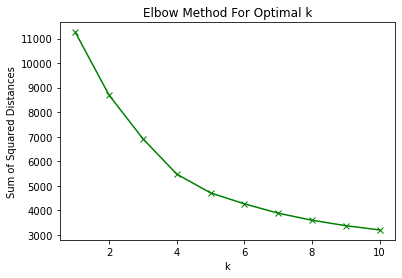

In [3]:
sum_squared_distances = []
K = range(1, 11)

#plot k for each value of K
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=1)
    km = km.fit(X)
    sum_squared_distances.append(km.inertia_)
plt.plot(K, sum_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [4]:
#based on the elbow method, let's choose 4 clusters and fit it into the model!
num_clusters = 4
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=1).fit(X)

## Cluster Visualization and Principle Component Analysis

Since our data is in 5 dimensions, we cannot visualize it. However, using principle component analysis (PCA), we can transform our 5-Dimensional data to 3-D data (or lower). It does not delete columns from our data (rather it creates principle components which basically represent the linear combination of each variable represented under the principle component). [For an overview of the process behind this linear algebra concept view this video](https://www.youtube.com/watch?v=FgakZw6K1QQ&t=244s). 

Once the dimensions are reduced, we can visualize our data. 

In [5]:
#reduce the dimensions to 3 components
pca = PCA(n_components=3, random_state=1)

#fitting and transforming our standardized data to the PCAs
pca_results = pca.fit_transform(X)

In [6]:
#view how much of the data is explained by the Principle Component Analysis
print("Reducing our data from 5 dimensions to 3 preserves", (round(pca.explained_variance_ratio_.sum(),4)*100), "percent of our data.")
print("The following array tells us how much each PCA component makes up that", (round(pca.explained_variance_ratio_.sum(),4)*100), "percent")
pca.explained_variance_ratio_.cumsum()

Reducing our data from 5 dimensions to 3 preserves 74.65 percent of our data.
The following array tells us how much each PCA component makes up that 74.65 percent


array([0.34666314, 0.55611804, 0.74649112])

In [7]:
#prepare data for a scree plot (plots the eigenvalues of PCAs)
df_scree_plot = pd.DataFrame({'Component': ['1','2','3'],'Indivual':pca.explained_variance_ratio_})
df_scree_plot['cum_sum'] = df_scree_plot['Indivual'].cumsum()
df_scree_plot

,Component,Indivual,cum_sum
0,1,0.346663,0.346663
1,2,0.209455,0.556118
2,3,0.190373,0.746491


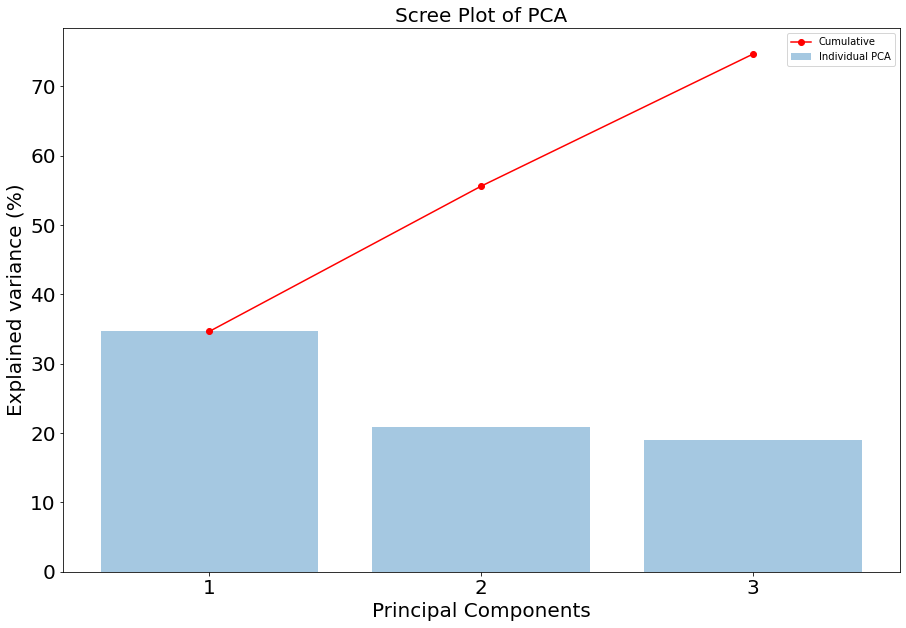

In [8]:
#create a scree plot 
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual PCA', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='red', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=20)
ax.set_yticklabels(range(0,90,10), fontsize=20)

plt.title('Scree Plot of PCA', fontsize=20)
plt.ylabel('Explained variance (%)', fontsize=20)
plt.xlabel('Principal Components', fontsize=20)
plt.legend()
plt.show()

__Now, that the dimensions of our data are reduced thanks to PCA, graph the data!__

__For this, we utilize both 2-D and 3-D models!__

In [9]:
#convert pca_results to a dataframe
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']

#add in the labels for each cluster (0-3)
df_pca['label'] = kmeanModel.labels_
df_pca

,PC1,PC2,PC3,label
0,0.868143,-0.077416,-0.226401,0
1,-0.915485,1.635577,0.114128,3
2,-0.371430,0.451619,-0.147533,3
3,0.004131,0.437942,-0.117078,0
4,-0.244236,1.391725,-0.001142,3
...,...,...,...,...
2246,0.186470,-0.174668,-0.023281,0
2247,1.852489,0.082276,-0.680675,1
2248,0.779270,0.694044,-0.398246,1
2249,0.500757,-1.644608,-0.407024,0


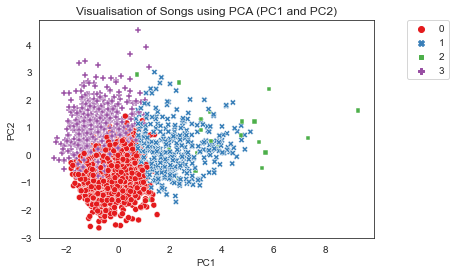

In [10]:
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA (PC1 and PC2)')
plt.show()

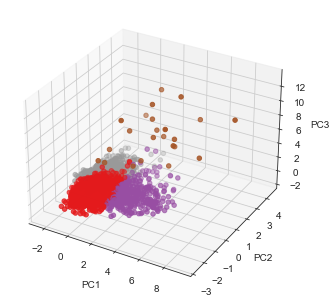

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

As noted in the two graphs above, __a huge chunk of songs share the same characteristics__. So much that it could also be reasonable to create two clusters for the hit songs data collected (one mega cluster and another smaller one for outliers). However, using the following graphs, we can conclude that the four clusters are still distinguishable in their own ways. 

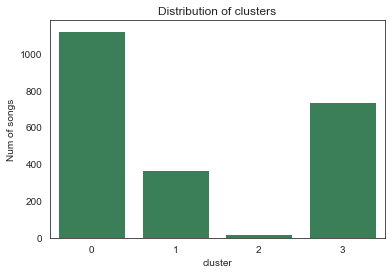

In [12]:
# assign label to recent dataframe
gsheets_df_updated.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = gsheets_df_updated.groupby('cluster').size().reset_index(name='Num of songs')
df_cluster_size
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show()

## Profiling Clusters

In order to understand how the clusters are different, we must create the following visualization and look at the means for each cluster: 

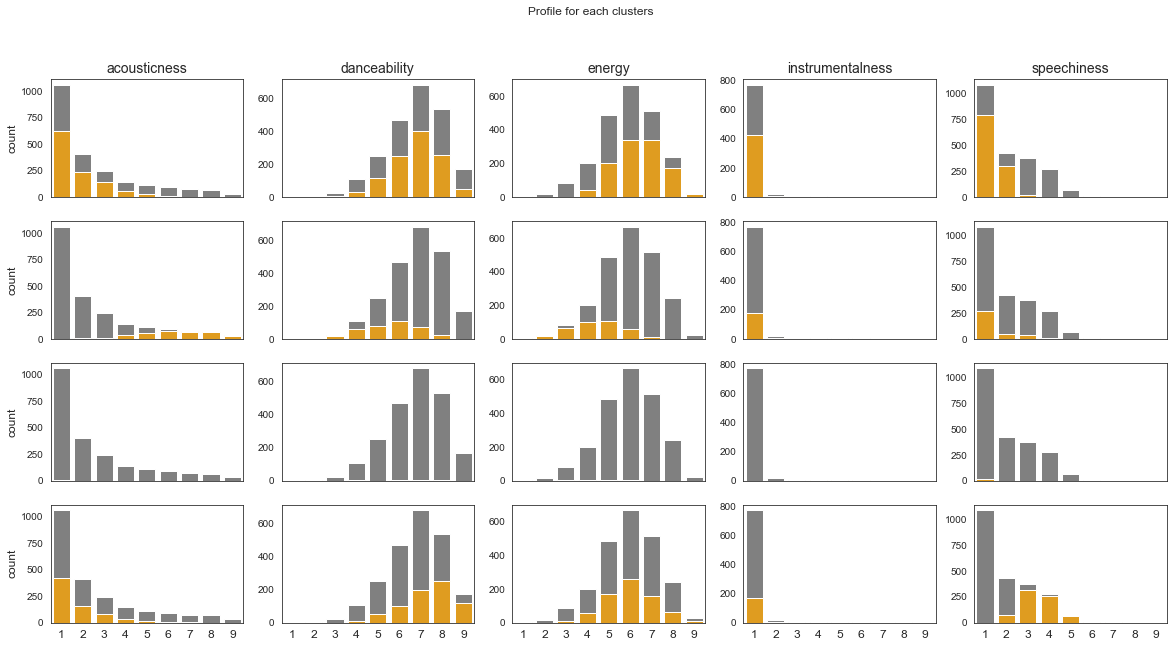

In [13]:
#set binning intervals of 0.1
bins = np.linspace(0,1,10)

#create subplots
num_features = len(var_to_cluster)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

#initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(gsheets_df_updated['cluster'].unique()):
    #filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster]
    col = 0
    
    for feature in var_to_cluster:
        
        #create binned count for all recent df and clustered df
        rec_grp = gsheets_df_updated.groupby(pd.cut(gsheets_df_updated[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
        #plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='orange', ax=axes[row, col])
        
        #configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')

    
plt.show()

In [14]:
#calculate mean of each variable
radar_col = var_to_cluster + ['cluster']

#feature average for each cluster as a radar chart
df_radar = gsheets_df_updated[radar_col]
df_radar = df_radar.groupby('cluster').mean().reset_index()
df_radar

,cluster,acousticness,danceability,energy,instrumentalness,speechiness
0,0,0.134345,0.695986,0.654468,0.002325,0.089823
1,1,0.631738,0.571257,0.432550,0.008158,0.101897
2,2,0.409069,0.587217,0.464904,0.577957,0.085035
3,3,0.132914,0.759834,0.610826,0.001264,0.331352


As noted from the visualization and the graph above, the clusters can be categorized with the following descriptions: 

* dancy/energetic with less speechiness
* acoustic/acoustic-leaning
* higher-than-normal instrumentality
* dancy/energetic with more speechiness

From here, we can create a spider chart to show how each cluster's mean characteristics look like.

In [15]:
from math import pi, ceil

# radar chart
def make_spider(row, title, color, df, num_clusters):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

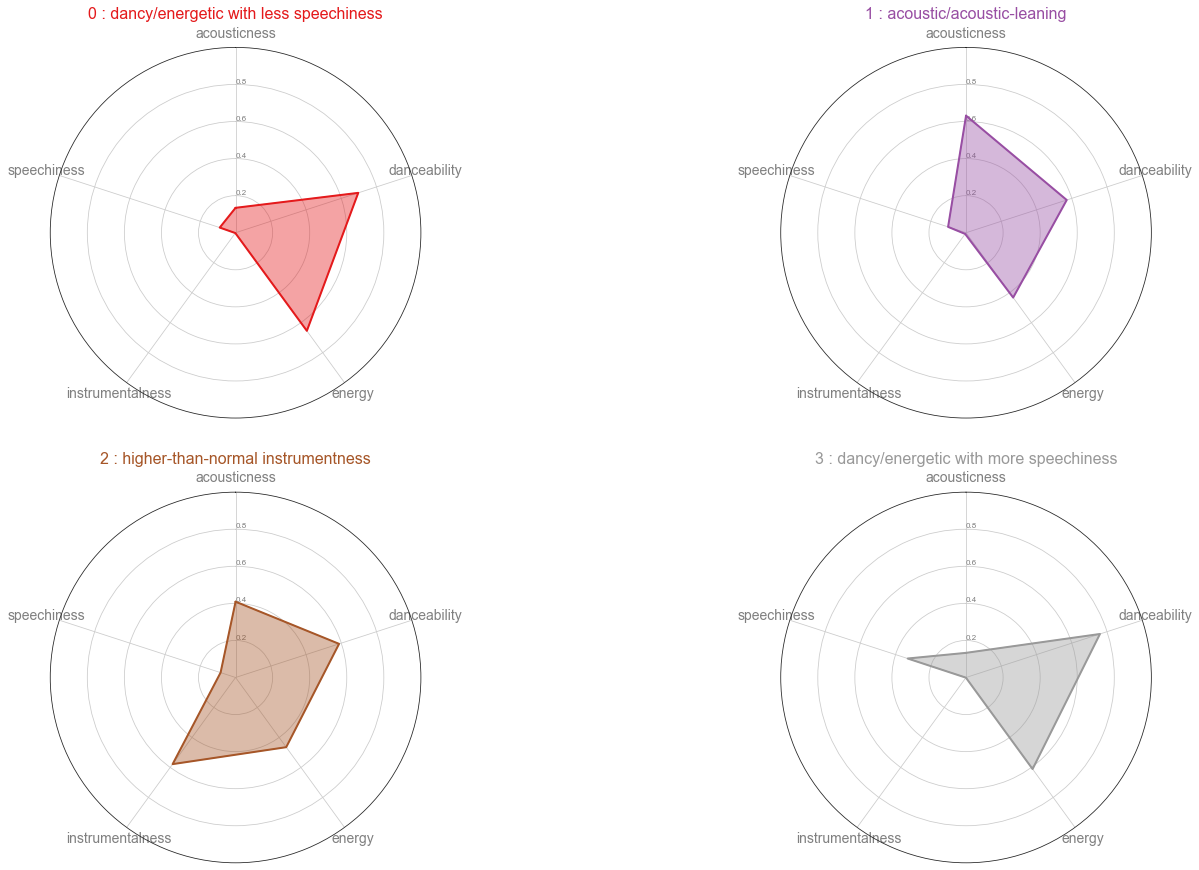

In [16]:
#list of titles for each cluster
title_list = ['dancy/energetic with less speechiness', 'acoustic/acoustic-leaning', 
              'higher-than-normal instrumentness', 'dancy/energetic with more speechiness']

# create figure
plt.figure(figsize=(24,15))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))

for row in range(0, len(df_radar.index)):
    make_spider(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), df=df_radar, num_clusters=len(df_radar.index))





## Randomly sampling songs from each cluster

From cluster 0: dancy/energetic with less speechiness

In [17]:
cluster_num = 0
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)


,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
1839,I Almost Do (Taylor's Version),Taylor Swift,Red (Taylor's Version),9119065,0.0167,0.511,0.559,0.000000,0.0264
406,Cudi Montage,KIDS SEE GHOSTS,KIDS SEE GHOSTS,14915729,0.4010,0.729,0.504,0.000001,0.0321
471,NO BYSTANDERS,Travis Scott,ASTROWORLD,44280927,0.0204,0.731,0.811,0.000000,0.0712
1539,Run It Up (feat. Offset & Moneybagg Yo),Lil Tjay,Destined 2 Win,17037242,0.4150,0.880,0.575,0.000000,0.1630
1257,Savage Love (Laxed – Siren Beat) [BTS Remix],Jawsh 685,Savage Love (Laxed - Siren Beat) [BTS Remix],230752185,0.1600,0.758,0.598,0.000000,0.0868


From cluster 1: acoustic/acoustic-leaning/slightly-more acoustic

In [18]:
cluster_num = 1
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)


,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
1708,Jonah,Kanye West,Donda,16098813,0.795,0.459,0.431,0.000000,0.2560
1852,My Little Love,Adele,30,24984360,0.829,0.339,0.492,0.003770,0.0559
1315,epiphany,Taylor Swift,folklore,11981685,0.731,0.354,0.267,0.000402,0.0281
1208,Party Girl,StaySolidRocky,Fallin',253110610,0.747,0.730,0.439,0.000000,0.0609
1378,Lonely (with benny blanco),Justin Bieber,Justice,60732410,0.900,0.619,0.241,0.000000,0.0460


From cluster 2: higher-than-normal instrumentness

In [19]:
cluster_num = 2
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)

,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
1681,Oxytocin,Billie Eilish,Happier Than Ever,7076077,0.0904,0.757,0.598,0.551,0.0580
1662,NDA,Billie Eilish,Happier Than Ever,9559632,0.3410,0.765,0.373,0.525,0.0713
746,goodbye,Billie Eilish,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",7533585,0.8370,0.153,0.138,0.550,0.0503
743,ilomilo,Billie Eilish,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",11536602,0.7240,0.855,0.423,0.469,0.0585
122,Close My Eyes,21 Savage,Issa Album,6636035,0.1640,0.921,0.472,0.432,0.4300


From cluster 3: dancy/energetic with more speechiness

In [20]:
cluster_num = 3
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)

,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
1948,What Happened To Virgil (feat. Gunna),Lil Durk,7220 (Deluxe),79497668,0.0670,0.795,0.526,0.000002,0.204
105,Good Drank,2 Chainz,Pretty Girls Like Trap Music,5871184,0.2740,0.836,0.776,0.000000,0.239
1607,Still Runnin (feat. Meek Mill),Lil Baby,The Voice of the Heroes,12486678,0.0130,0.856,0.727,0.000000,0.277
2049,We Cry Together,Kendrick Lamar,Mr. Morale & The Big Steppers,18290584,0.2920,0.648,0.680,0.000000,0.345
487,Missing My Idols,Trippie Redd,LIFE'S A TRIP,7659370,0.0598,0.706,0.637,0.000000,0.370


## Conclusion

By this point of the project, it is safe to say characterstics of popular music since 2017 have changed in some ways (for more information please reference the part 2 of this project).

In terms of the clustering models, 4 main clusters were found. Many of the clusters shared similar characteristics, with a notable presence of danceability and energy. Instrumentalness and acousticness set apart many songs from the others. 

Overall, it would be interesting to see if the recent rise in house/dance music tracks in Summer 2022 (thanks to Drake and Beyonce) have a lasting impact on popular music throughout the next several months! This could cause more songs to land in cluster_num 3 (which hosts songs with higher-than-usual instrumentalness). Another thing that could add more to cluster 3 would be a resurgance of EDM music in the mainstream!

This concludes the analytical portion of this project. Part 4 is a fun playlist creator to listen to all songs that charted in the top 50!